### ResNet for Waste Sorting

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import copy
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import random
import matplotlib.pyplot as plt

In [3]:
!rm -r data
!rm -r dataset-resized

In [4]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

In [5]:
os.listdir(os.path.join(os.getcwd(),'dataset-resized'))

['paper', '.DS_Store', 'metal', 'cardboard', 'trash', 'glass', 'plastic']

In [6]:
## helper functions ##

## splits indices for a folder into train, validation, and test indices with random sampling
    ## input: folder path
    ## output: train, valid, and test indices    
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    ## temp
    remain = list(set(full_set)-set(train))

    ## separate remaining into validation and test
    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [7]:
## paths will be train/cardboard, train/glass, etc...
subsets = ['train','val','test']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to valid
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/val/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    test_dest = "data/test/"+waste_type
    ## I use data/test here because the images can be mixed up
    move_files(test_source_files,test_dest)

In [8]:
## get a path to the folder with images
path = Path(os.getcwd())/"data"
path

PosixPath('/Users/samuelha/github/w281/281-final-project-sompalli-ha-tang-wong/data')

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'

## Dataset stores samples and corresponding labels
## 1st parameter is root, and 2nd parameter is transform which takes a PIL image and returns a transformed version
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

## Dataloader wraps an iterable around the dataset, 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

## Test dataset
test_image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['test']}
## Test dataloader
test_dataloader = {x: torch.utils.data.DataLoader(test_image_dataset[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['test']}
test_dataset_sizes = {x: len(test_image_dataset[x]) for x in ['test']}

test_class_names = test_image_dataset['test'].classes

## Use GPU (Apple Metal)
device = torch.device("mps")

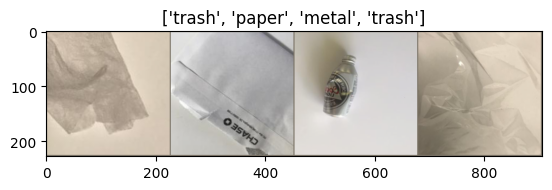

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/Users/samuelha/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/samuelha/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/samuelha/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 34.5MB/s]


In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4340 Acc: 0.4770
val Loss: 1.0637 Acc: 0.6921

Epoch 1/24
----------
train Loss: 1.2361 Acc: 0.5697
val Loss: 0.9618 Acc: 0.6857

Epoch 2/24
----------
train Loss: 1.1346 Acc: 0.5959
val Loss: 0.6493 Acc: 0.7730

Epoch 3/24
----------
train Loss: 1.0408 Acc: 0.6529
val Loss: 0.6144 Acc: 0.7778

Epoch 4/24
----------
train Loss: 1.0290 Acc: 0.6371
val Loss: 0.6753 Acc: 0.7889

Epoch 5/24
----------
train Loss: 0.9168 Acc: 0.6767
val Loss: 0.7263 Acc: 0.7841

Epoch 6/24
----------
train Loss: 0.8811 Acc: 0.6894
val Loss: 0.7465 Acc: 0.7873

Epoch 7/24
----------
train Loss: 0.6327 Acc: 0.7726
val Loss: 0.4010 Acc: 0.8778

Epoch 8/24
----------
train Loss: 0.4793 Acc: 0.8352
val Loss: 0.3803 Acc: 0.8714

Epoch 9/24
----------
train Loss: 0.5470 Acc: 0.8146
val Loss: 0.3808 Acc: 0.8825

Epoch 10/24
----------
train Loss: 0.5104 Acc: 0.8336
val Loss: 0.4197 Acc: 0.8667

Epoch 11/24
----------
train Loss: 0.4471 Acc: 0.8542
val Loss: 0.3525 Acc: 0.8937

Ep

In [15]:
# Saving model serializing the internal state dictionary
# torch.save(model_ft.state_dict(), "model_ft.pth")
# print("Saved PyTorch Model State to model_ft.pth")

In [16]:
# Loading model by recreating the model structure and loading state dictionary
# model_ft = models.resnet18(pretrained=True)
# model.load_state_dict(torch.load("model_ft.pth"))

# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 6)

# model_ft = model_ft.to(device)

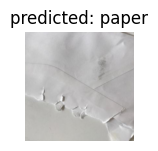

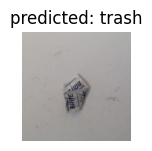

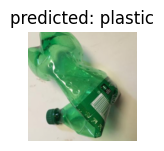

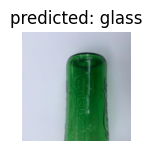

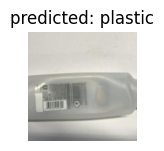

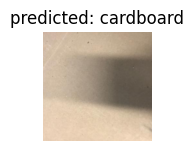

In [17]:
visualize_model(model_ft)

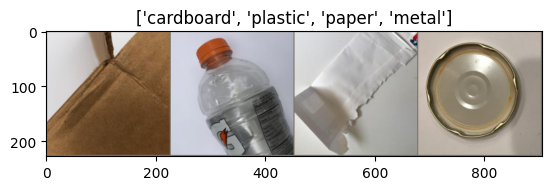

In [18]:
# Get a batch of testing data
inputs, classes = next(iter(test_dataloader['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [64]:
model_ft.eval()
# x, y = test_image_dataset[0][0], test_image_dataset[0][1]
# print(x, y)

correct = 0
total = 0

y_pred = []
y_true = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader['test']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 90.70866141732283 %


In [60]:
# Checking code and label correspondences
print("Train:", image_datasets['train'].class_to_idx)
print("Validation:", image_datasets['val'].class_to_idx)
print("Test:", test_image_dataset['test'].class_to_idx)


Train: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Validation: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Test: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


<Axes: >

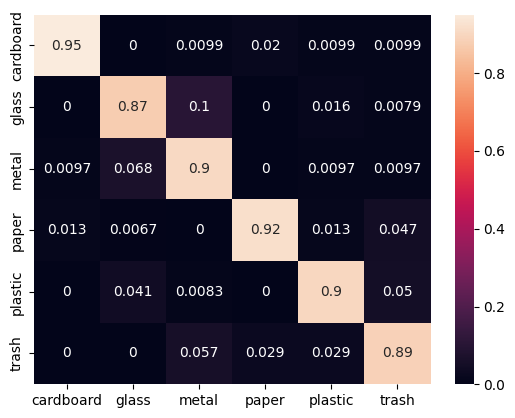

In [63]:
# Build confusion matrix
from sklearn.metrics import confusion_matrix

classes = ('cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure()
sns.heatmap(df_cm, annot=True)
